# Quick start to KinFragLib

Introduction on how to load and use the fragment library

In [1]:
from pathlib import Path

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools

from util import read_fragment_library, most_common_fragments, draw_fragmented_ligand

### 1. Access fragment library:

In [2]:
# Path to library folder
PATH_TO_LIB = Path('.') / '..' / 'data' / 'fragment_library'

In [3]:
# use utils function to read fragment library
fragment_library = read_fragment_library(PATH_TO_LIB)
fragment_library.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])

*fragment_library* is a dictionary containing a pandas dataframe for each of the six subpockets (AP, FP, SE, GA, B1, B2) and the X pool.

For each fragment in each subpocket it contains the RDKit molecule object, the SMILES string, the kinase group and PDB codes of the structure from which the fragment originated.

#### Access fragments in specific subpocket (here AP):

In [4]:
AP_fragments = fragment_library['AP']
print('Shape of AP_fragments df: ',AP_fragments.shape)
print('with the following columns: ', AP_fragments.columns.to_list())
AP_fragments.head()

Shape of AP_fragments df:  (2561, 11)
with the following columns:  ['smiles', 'fragment', 'kinase', 'family', 'group', 'complex_pdb', 'ligand_pdb', 'alt', 'chain', 'atom_subpockets', 'atom_environments']


,smiles,fragment,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments
0,Nc1c[nH]c2ncccc12,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na
1,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...
2,Cc1cc(N)[nH]n1,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na
3,Nc1ncc(C=O)s1,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na
4,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,"<img src=""data:image/png;base64,iVBORw0KGgoAAA...",ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...


#### Draw sample set of fragments

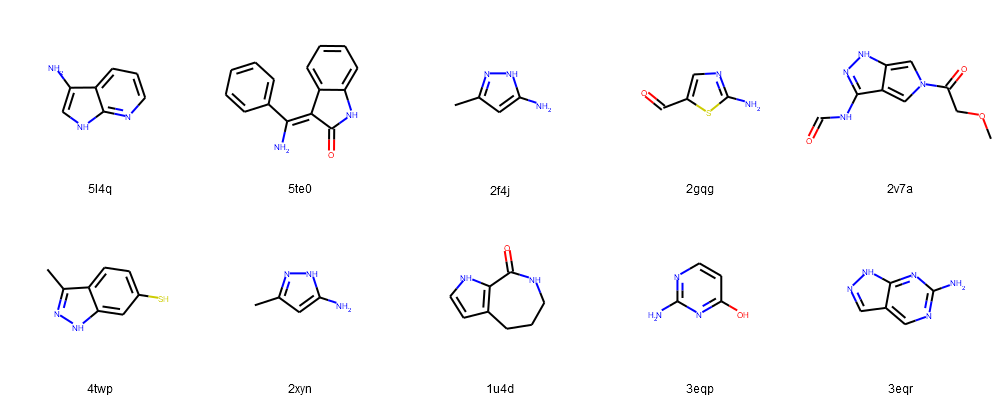

In [5]:
# Add molecule column to dataframe
PandasTools.AddMoleculeColumnToFrame(AP_fragments,'smiles')
Draw.MolsToGridImage(AP_fragments.ROMol[:10], legends=AP_fragments.complex_pdb.to_list(), molsPerRow=5)

The fragments can either be loaded without dummy atoms (default (as used above); dummy atoms are replaced with hydrogens) or with dummy atoms present.

#### Load fragments with dummy atoms:

In [6]:
fragment_library_dummy_atoms = read_fragment_library(PATH_TO_LIB, remove_dummy=False)

In [7]:
AP_fragments_dummy_atoms = fragment_library_dummy_atoms['AP']

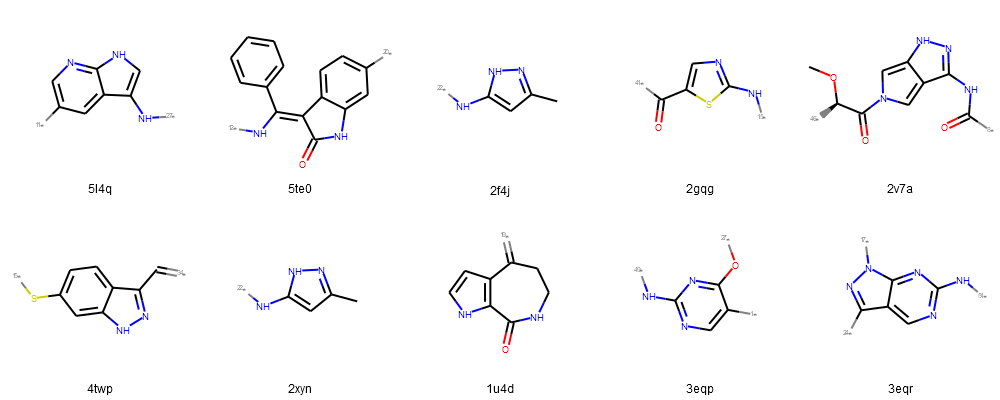

In [8]:
# Add molecule column to dataframe
PandasTools.AddMoleculeColumnToFrame(AP_fragments_dummy_atoms,'smiles')
Draw.MolsToGridImage(AP_fragments_dummy_atoms.ROMol[:10], legends=AP_fragments_dummy_atoms.complex_pdb.to_list(), molsPerRow=5)

#### Show fragments with and without dummy atoms next to each other:

In [9]:
# rename respective columns
AP_fragments_dummy_atoms = AP_fragments_dummy_atoms.rename(
    columns={"smiles": "smiles_dummy_atoms", "fragment": "fragment_dummy_atoms"})

In [10]:
# concatenate both dfs
pd.concat([AP_fragments, AP_fragments_dummy_atoms], axis=1, join='inner') \
            [['smiles', 'smiles_dummy_atoms']].head()

,smiles,smiles_dummy_atoms
0,Nc1c[nH]c2ncccc12,[11*]c1cnc2[nH]cc(N[27*])c2c1
1,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1
2,Cc1cc(N)[nH]n1,[22*]Nc1cc(C)n[nH]1
3,Nc1ncc(C=O)s1,[15*]Nc1ncc(C([41*])=O)s1
4,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12


### 2. View all fragments of a specific inhibitor (here Gefitinib - PDB idetifier: IRE):

This analysis could be used to investigate, how differnet orientations/binding modi of the same molecules co-crystallized to different structures affects the subpocket assignement.

In [11]:
IRE_fragment_list = []

#### Find IRE fragments in each subpocket

In [12]:
# loop over each subpocket in fragment library
for subpocket in fragment_library_dummy_atoms.keys():
    # collect all fragments for subpocket
    subpocket_fragments = fragment_library_dummy_atoms[subpocket]
    # store only fragments that came from ligand IRE
    IRE_subpocket_fragments = subpocket_fragments[subpocket_fragments.ligand_pdb == 'IRE']
    # gather information
    IRE_subpocket_fragment_list = [frag.SetProp('subpocket', subpocket) for frag in 
                                   list(IRE_subpocket_fragments.fragment)]
    
    IRE_fragment_list.extend(list(IRE_subpocket_fragments.fragment))

In [13]:
print('Kinases the ligand bind to:',set([frag.GetProp('kinase') for frag in IRE_fragment_list]))
print('List of PDBs:',set([frag.GetProp('complex_pdb') for frag in IRE_fragment_list]))

Kinases the ligand bind to: {'GAK', 'EGFR'}
List of PDBs: {'5y80', '2ity', '5y7z', '2itz', '3ug2', '4wkq', '2ito', '4i22'}


#### Draw sample ligand fragmentation

Draw fragments for PDB structure 2ito  and ligand IRE


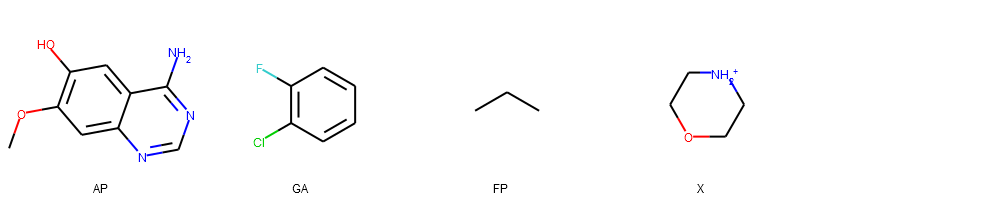

In [14]:
id = 0
pdb=IRE_fragment_list[0].GetProp('complex_pdb')
ligand= IRE_fragment_list[0].GetProp('ligand_pdb')
print('Draw fragments for PDB structure', pdb, ' and ligand', ligand)
draw_fragmented_ligand(fragment_library, pdb, ligand, mols_per_row=5)

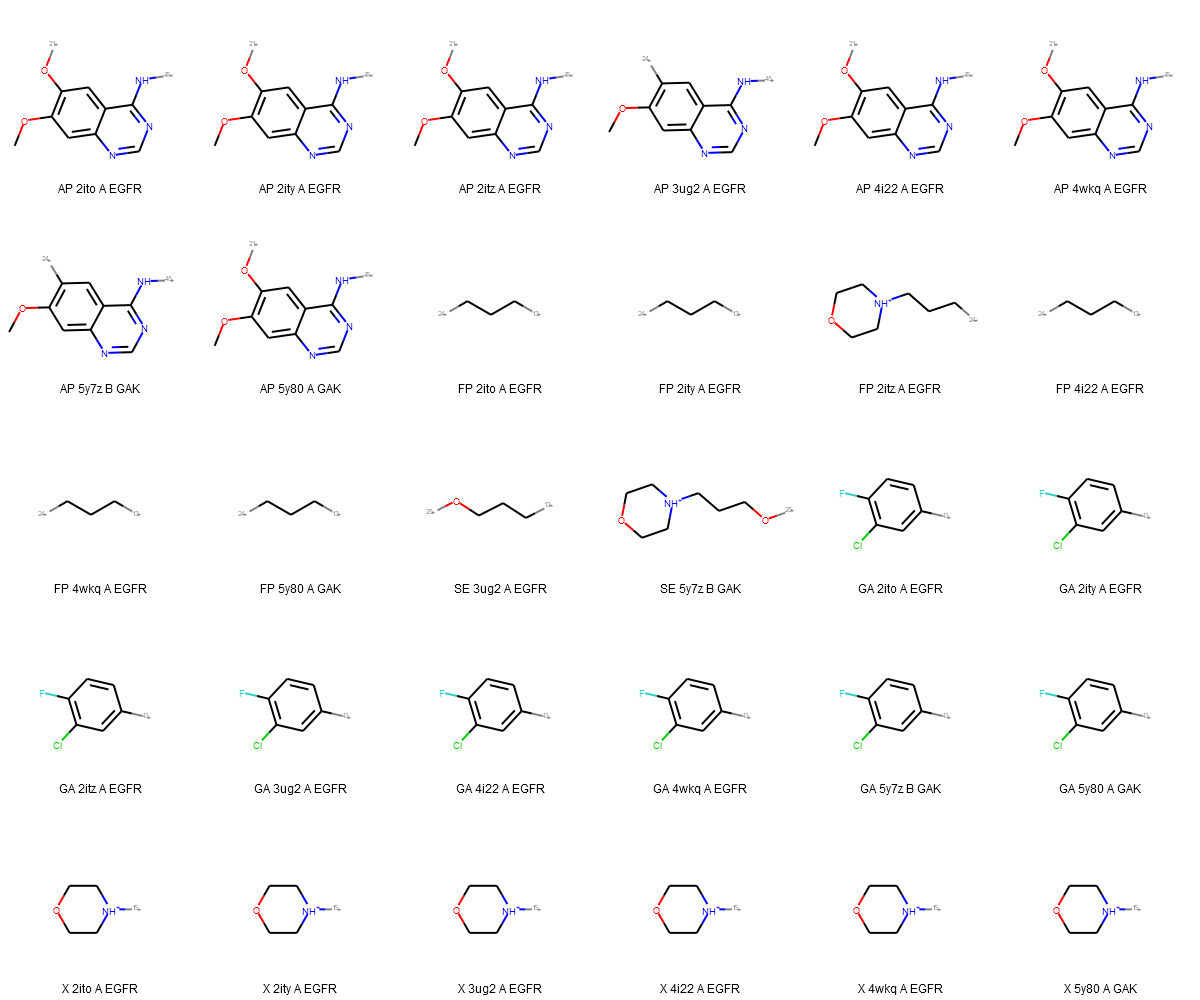

In [15]:
Draw.MolsToGridImage(IRE_fragment_list, 
                     legends=[frag.GetProp('subpocket')
                              +' '+frag.GetProp('complex_pdb')
                              +' '+frag.GetProp('chain') 
                              +' '+frag.GetProp('kinase') 
                              for frag in IRE_fragment_list], 
                     molsPerRow=6)

##### Discussion:
The above figure shows that
* The hinge binding fragments clearly lie in AP in all structures, only difference 
    - Neighboring Oxygen is in some structures part of AP
    - In others it was assigned to FP (3ug2, 5y7z)
* The halogenetated benzene ring is clearly assigned to GA in all structures
* In contrast the long solvent exposed tail is very flexible, and can thus, be assigned to
    - FP or SE 
    - and even be further split, with the terminal ring being annotated to pool X

### 3. Identify most common fragments in a subpocket (here AP):

In [16]:
# use utils function to count fragment occurances
mols, mols_count = most_common_fragments(AP_fragments, top_x=25)

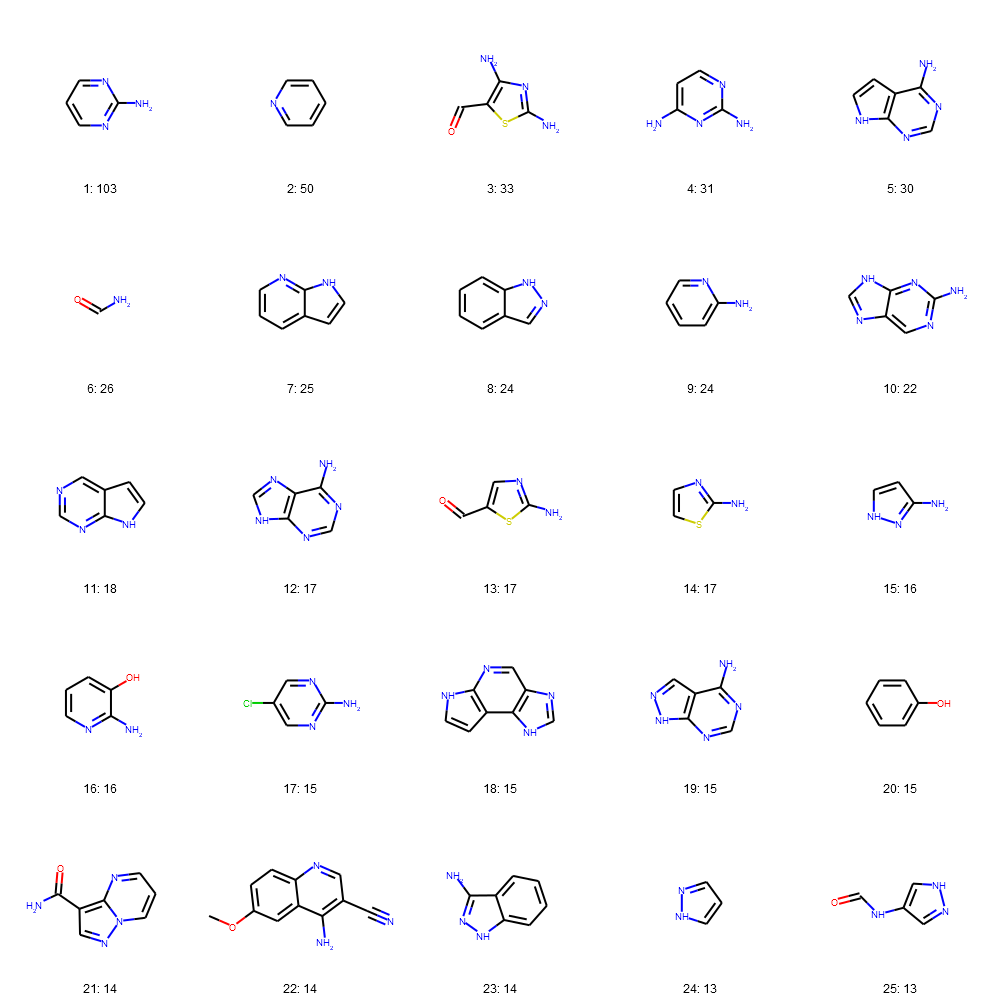

In [17]:
Draw.MolsToGridImage(mols, legends=[str(i+1)+': '+str(x) for i, x in enumerate(mols_count)], molsPerRow=5)

### Analyze the occurances of a specific fragment 
Select a fragment from the AP most common fragments

In [18]:
query_smiles= Chem.MolToSmiles(mols[0])
print(query_smiles)

Nc1ncccn1


In [19]:
AP_fragments_subset=AP_fragments[AP_fragments.smiles==query_smiles]

In [20]:
print('List of pdb codes, from which the fragment originated:\n', AP_fragments_subset.complex_pdb.to_list())

List of pdb codes, from which the fragment originated:
 ['4dce', '4fnz', '6acr', '4xv2', '4xv3', '5csw', '5hie', '6gu3', '6gu7', '1h01', '1oir', '1oit', '1pxi', '1pxj', '1pxl', '1pxm', '1pxn', '1pxo', '1pxp', '1urw', '2c5n', '2c5o', '2c5v', '2uue', '2w05', '2w06', '2wev', '2xmy', '2xnb', '3ej1', '3sw4', '3sw7', '3unj', '4ek8', '4fkl', '4fko', '5iev', '5iey', '5k4j', '6gue', '6guh', '3uyt', '3uzp', '4tn6', '6gro', '4zau', '4fux', '4xj0', '5bvd', '5bve', '5bvf', '5k4i', '5ngu', '5nhf', '5nhh', '5nhj', '5nhp', '5nhv', '6gjb', '6oph', '3bz3', '3du8', '3qqu', '4d2r', '4u6r', '6dbn', '4bbe', '4bbf', '4d0w', '4d0x', '4d1s', '4hys', '4hyu', '4izy', '1pmn', '3cgo', '3kvx', '4kkh', '4u79', '3cjg', '4c3f', '4o0t', '4o0v', '4a4l', '4a4o', '5ar8', '1y57', '1xbb', '3emg', '4rss', '4xg7', '4xg9', '4yjp', '4yjq', '4yjs', '5ghv', '2x4f', '4d2s', '6dbk', '6dbm', '1bl7', '1bmk', '3fmj']


Draw fragments for PDB structure 4dce  and ligand 0JF


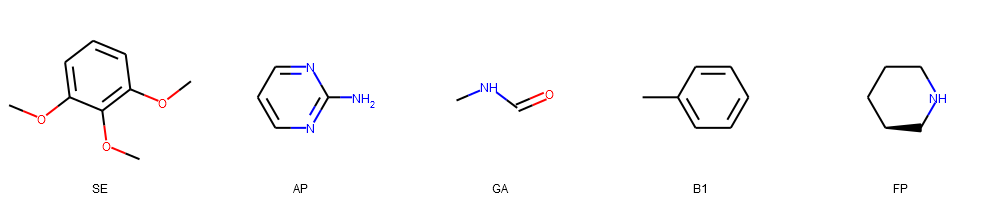

In [21]:
id = 0
pdb=AP_fragments_subset.complex_pdb.values[id]
ligand= AP_fragments_subset.ligand_pdb.values[id]
print('Draw fragments for PDB structure', pdb, ' and ligand', ligand)
draw_fragmented_ligand(fragment_library, pdb, ligand, mols_per_row=5)